### Maor Gaon 301308821, Eyal Gutflaish 066745878

In [24]:
%%javascript
Jupyter.notebook.config.update(
    {"load_extensions":{"calico-spell-check":true,
                        "calico-document-tools":true,
                        "calico-cell-tools":true}})

<IPython.core.display.Javascript object>

In [25]:
%matplotlib inline
from __future__ import print_function
from __future__ import division
from __builtin__ import range
from utils import *
from utils.utils import y2row
from utils.py27lru import lru_cache
from itertools import product

In [26]:
def sum_neighbors(I):
    return (I[:, 1:] * I[:, :-1]).sum() + (I[1:, :] * I[:-1, :]).sum()


def all_perm(isize):
    for per in (y2row(i, isize) for i in range(2**isize)):
        yield per


@lru_cache()
def ising_Z(ishape, Temp=1):
    Z = sum(np.exp((1 / Temp) * sum_neighbors(X.reshape(ishape))) 
            for X in all_perm(ishape[0] * ishape[1]))
    return Z


def ising_prob(X, Temp=1):
    Z = ising_Z(X.shape, Temp)
    return (1 / Z) * np.exp((1 / Temp) * sum_neighbors(X))

# Computer Exercise 1

In [27]:
print("Z: {:.4E}".format(ising_Z((2,2))))

Z: 1.2123E+02


# Computer Exercise 2

In [28]:
print("Z: {:.4E}".format(ising_Z((3,3))))

Z: 3.6565E+05


# Computer Exercise 3

In [33]:
def ising_g(Xs, Temp=1):
    return np.exp((1 / Temp) * (Xs[1:] * Xs[:-1]).sum())


def ising_h(ys, yns, row_size, Temp=1):
    Xs = y2row(ys, row_size)
    Xns = y2row(yns, row_size)
    return ising_g(Xs, Temp) * np.exp((1 / Temp) * (Xs * Xns).sum())


@lru_cache(maxsize=524288)
def ising_t(row_size, k, ynk=None, Temp=1):
    isize = 2 ** row_size
    if ynk is None:
        return sum(ising_t(row_size, k - 1, y_last, Temp) *
                   ising_g(y2row(y_last, row_size), Temp)
                   for y_last in range(isize))
    if k == 0:
        return sum(ising_h(y1, ynk, row_size, Temp) 
                   for y1 in range(isize))
    return sum(ising_t(row_size, k - 1, yk, Temp) * 
               ising_h(yk, ynk, row_size, Temp)
               for yk in range(isize))


def ising_sample_prob(ishape, Temp=1):
    isize = 2 ** ishape[0]
    Z = ising_t(ishape[0], ishape[0] - 1, Temp=Temp)
    p = np.asarray([((ising_t(ishape[0], ishape[0] - 2, last_y, Temp) *
                    ising_g(y2row(last_y, ishape[0]), Temp)) / Z)
                    for last_y in range(isize)])
    post_mat = np.zeros((ishape[0] - 1, 2**ishape[0], 2**ishape[1]))
    for k, yk, ynk in product(range(ishape[0] - 2, 0, -1), 
                              range(isize), range(isize)):
        post_mat[k, yk, ynk] = (ising_t(ishape[0], k - 1, yk, Temp) *
                                ising_h(yk, ynk, ishape[0], Temp)) /\
                                ising_t(ishape[0], k, ynk, Temp)
    for y1, y2 in product(range(isize), range(isize)):
        post_mat[0, y1, y2] = ising_h(y1, y2, ishape[0], Temp) /\
                              ising_t(ishape[0], 0, y2, Temp)
    return p, post_mat


def ising_sample_image(p, post_mat, ishape, THRESH=125):
    I = np.zeros(ishape)
    y = np.random.choice(p.shape[0], size=1, p=p)[0]
    I[ishape[0] - 1, np.where(y2row(y, ishape[0]) == 1)] = 1
    for k in range(ishape[0] - 2, -1, -1):
        tp = post_mat[k, :, y]
        y = np.random.choice(p.shape[0], size=1, p=tp)[0]
        I[k, np.where(y2row(y, ishape[0]) == 1)] = 1
    return I

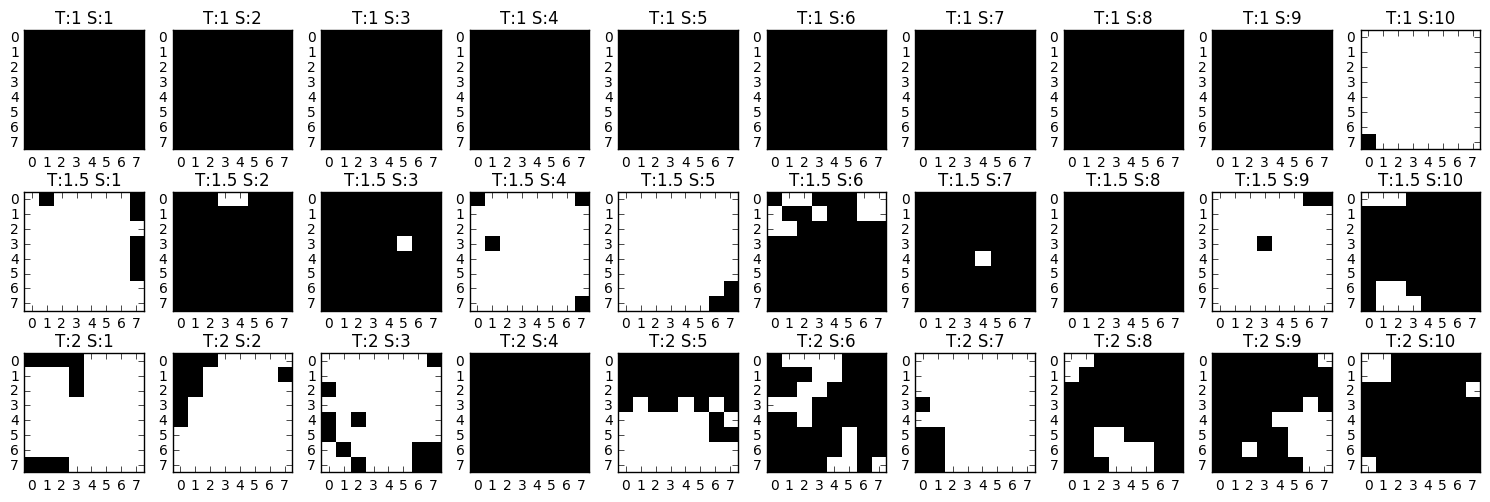

In [34]:
FIGS=10
plt.figure(30, figsize=(15, 5))
plt.set_cmap('gray')
temp_list = [1, 1.5, 2]
ishape = (8, 8)
for i, temp in enumerate(temp_list):
    p, post_mat = ising_sample_prob(ishape, temp)
    for j in range(FIGS):
        sample_image = ising_sample_image(p, post_mat, ishape)
        plt.subplot(len(temp_list), FIGS, (i*FIGS)+j+1)
        plt.title("T:{} S:{}".format(temp, j + 1))
        plt.imshow(sample_image, interpolation='nearest')
plt.tight_layout()

# Computer Exercise 4

In [23]:
temp_list = [1, 1.5, 2]
ishape = (8, 8)
for temp in temp_list:
    p, post_mat = ising_sample_prob(ishape, temp)
    E_11_22 = 0
    E_11_88 = 0
    for j in range(10000):
        sample_image = ising_sample_image(p, post_mat, ishape)
        sample_image[np.where(sample_image == 0)] = -1
        E_11_22 += sample_image[0, 0] * sample_image[1, 1] 
        E_11_88 += sample_image[0, 0] * sample_image[-1, -1]
    E_11_22 /= 10000
    E_11_88 /= 10000
    print("Temp: {} E_11_22: {} E_11_88: {}".format(
          temp, E_11_22, E_11_88))

Temp: 1 E_11_22: 0.953 E_11_88: 0.9064
Temp: 1.5 E_11_22: 0.7758 E_11_88: 0.5554
Temp: 2 E_11_22: 0.5144 E_11_88: 0.1322


# Execise 1

The 'hotter the temreture' (higher value) the more impact on spatial distance, hence for higher tempreture, pixels farther apart are less likely to obtain the same value.